In [1]:
using Pkg
Pkg.add("Oceananigans")
Pkg.add("JLD2")
Pkg.add("Statistics")
Pkg.add("DataDeps")
Pkg.add("CairoMakie")
Pkg.add("Plots")
Pkg.add("KernelAbstractions")

    Updating registry at `/opt/julia/registries/General.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `/opt/julia/environments/v1.7/Project.toml`
  No Changes to `/opt/julia/environments/v1.7/Manifest.toml`
   Resolving p

In [2]:
using Oceananigans
using Oceananigans.Solvers
using Oceananigans.Models.NonhydrostaticModels: solve_for_pressure!
using Oceananigans.BoundaryConditions: fill_halo_regions!
using Plots
using KernelAbstractions: @kernel, @index, Event
using Oceananigans.Architectures: child_architecture, device, array_type
using Oceananigans.Utils: launch!
using Oceananigans.Operators: ∇²ᶜᶜᶜ, divᶜᶜᶜ
arch=CPU()
FT=Float64;

In [3]:
function compute_∇²!(∇²ϕ, ϕ, arch, grid)
    fill_halo_regions!(ϕ)
    child_arch = child_architecture(arch)
    event = launch!(child_arch, grid, :xyz, ∇²!, ∇²ϕ, grid, ϕ, dependencies=Event(device(child_arch)))
    wait(device(child_arch), event)
    fill_halo_regions!(∇²ϕ)
    return nothing
end
@kernel function ∇²!(∇²f, grid, f)
    i, j, k = @index(Global, NTuple)
    @inbounds ∇²f[i, j, k] = ∇²ᶜᶜᶜ(i, j, k, grid, f)
end
@kernel function divergence!(grid, u, v, w, div)
    i, j, k = @index(Global, NTuple)
    @inbounds div[i, j, k] = divᶜᶜᶜ(i, j, k, grid, u, v, w)
end

divergence! (generic function with 5 methods)

In [4]:
Lx=1
Ly=1
Nx=200
Ny=200
grid=RectilinearGrid(arch,FT,size=(Nx,Ny),extent=(Lx,Ly), topology=(Periodic, Periodic, Flat))
u=XFaceField(grid);set!(u,rand(Nx,Ny));fill_halo_regions!(u)
v=YFaceField(grid);set!(v,rand(Nx,Ny));fill_halo_regions!(v)
w=ZFaceField(grid);set!(w,rand(Nx,Ny));fill_halo_regions!(w)
U=(u=u,v=v,w=w)
ϕ=CenterField(grid)
∇²ϕ=CenterField(grid)

200×200×1 Field{Center, Center, Center} on RectilinearGrid on CPU
├── grid: 200×200×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Periodic, north: Periodic, bottom: Nothing, top: Nothing, immersed: ZeroFlux
└── data: 206×206×1 OffsetArray(::Array{Float64, 3}, -2:203, -2:203, 1:1) with eltype Float64 with indices -2:203×-2:203×1:1
    └── max=0.0, min=0.0, mean=0.0

In [5]:
solver = FFTBasedPoissonSolver(grid)

FFTBasedPoissonSolver on CPU: 
├── grid: 200×200×1 RectilinearGrid{Float64, Periodic, Periodic, Flat} on CPU with 3×3×0 halo
├── storage: Array{ComplexF64, 3}
├── buffer: Nothing
└── transforms:
    ├── forward: Oceananigans.Solvers.DiscreteTransform, Oceananigans.Solvers.DiscreteTransform
    └── backward: Oceananigans.Solvers.DiscreteTransform, Oceananigans.Solvers.DiscreteTransform

In [6]:
solve_for_pressure!(ϕ.data, solver, 1, U)

In [7]:
compute_∇²!(∇²ϕ, ϕ, arch, grid)

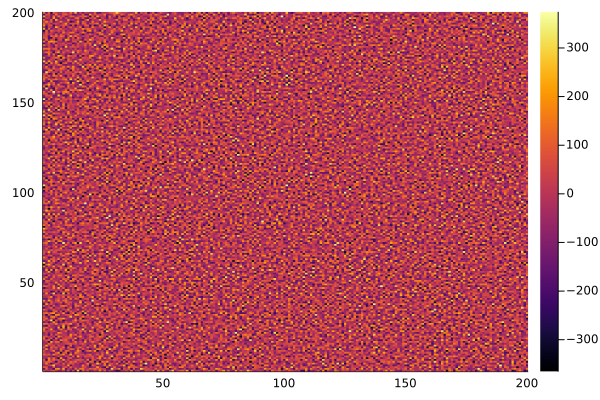

In [8]:
Plots.heatmap(interior(∇²ϕ)[:,:,1])

In [9]:
divU=zeros(Nx, Ny, 1) |> array_type(arch)
event = launch!(arch, grid, :xyz, divergence!, grid, u.data, v.data, w.data, divU,
                    dependencies=Event(device(arch)))
wait(device(arch), event)

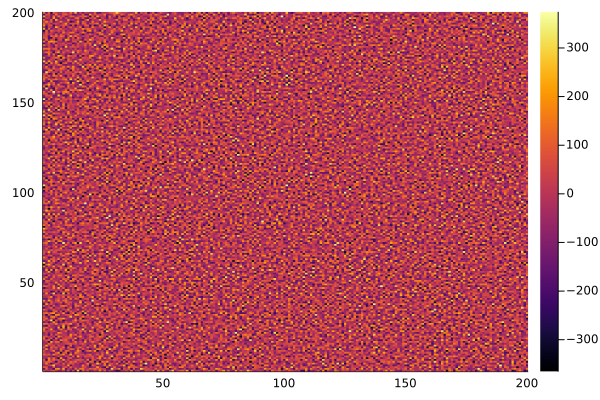

In [10]:
Plots.heatmap(divU[:,:,1])

In [11]:
maximum(divU[:,:,1].-interior(∇²ϕ)[:,:,1]), minimum(divU[:,:,1].-interior(∇²ϕ)[:,:,1])

(2.2737367544323206e-13, -2.5579538487363607e-13)